Тема: Обработка изображений
Цель: сосчитать количество очков выпавших на игральных кубиках на картинке

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import ndimage
from PIL import Image
import imageio
%matplotlib inline

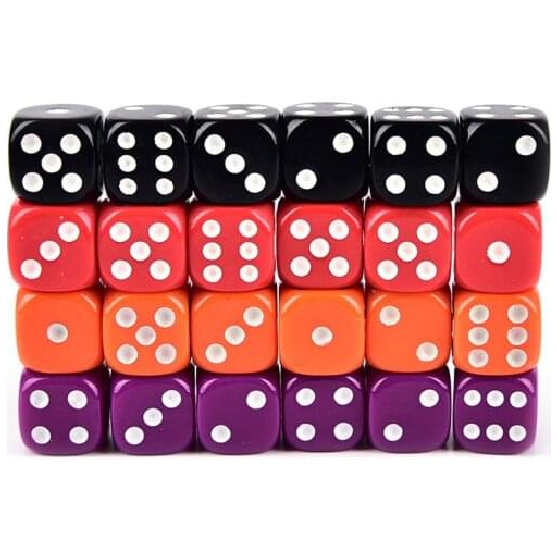

In [152]:
img = Image.open('./image.jpg')

fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(img) # RGB scale
                
plt.axis('off')
plt.show()

In [153]:
img.size

(500, 500)

In [154]:
red, green, blue = img.split() #Pillow, разбиваем на цветовые каналы и выводим три изображения, выбираем colormap 'gray'

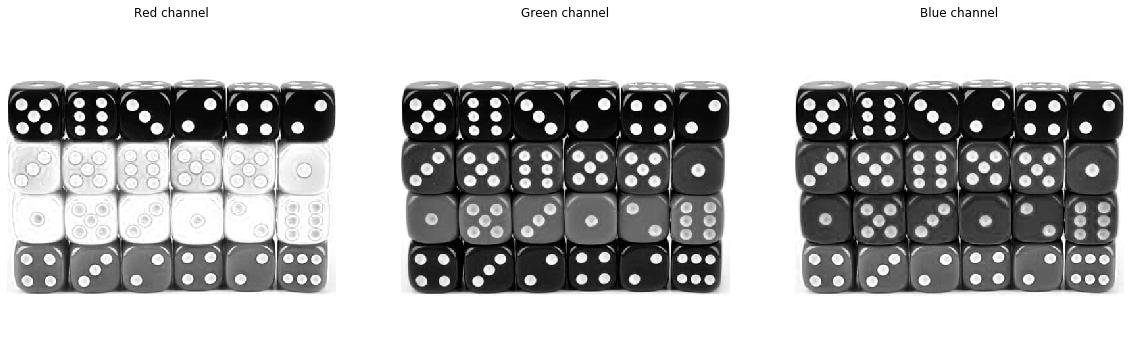

In [155]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 3, 1)

plt.title('Red channel')
plt.imshow(red, cmap = cm.gray)
ax.axis('off')

ax = fig.add_subplot(1, 3, 2)
plt.title('Green channel')
plt.imshow(green, cmap = cm.gray)
ax.axis('off')

ax = fig.add_subplot(1, 3, 3)
plt.title('Blue channel')
plt.imshow(blue, cmap = cm.gray)
ax.axis('off')

plt.show()

In [156]:
#переводим в массив numpy каждый канал
red = np.array(red)
green = np.array(green)
blue = np.array(blue)
#для примера выводим срез одного из каналов (#120-й, 121-и пиксели из 500 в green канале)
green[120:122] #нам нужен канал с большей контрастностью - это green

array([[255, 205,  28,  28,  79,  76,  62,  19,   3,   0,  15,  14,   0,
         36, 154, 249, 226, 222, 217, 214, 214, 215, 215, 215, 218, 220,
        222, 237, 247, 171,  44,   0,   9,   9,   9,  10,  10,  11,  11,
         11,   8,   8,   8,   8,   8,   8,   8,   8,   8,   7, 100, 220,
        252, 236, 232, 233, 228, 227, 227, 228, 231, 234, 238, 240, 239,
        147,  35,   0,   2,  17,  10,   6,   4,   9,  16,  61, 140, 145,
         66,  16,   5,   9,  13,  23,  29,  20,  18,  34,  10,  13,  10,
          3,  73,  96,  19,  12,  10,   4,  20,  17,   0,  83, 219, 248,
        249, 248, 242, 230, 216, 211, 212, 218, 239, 247, 247, 242, 245,
        137,   0,   6,  13,  12,  11,  10,   8,   7,   6,   6,   2,  16,
         14,   2,   8,   1,  15, 102, 253, 254, 244, 240, 243, 235, 225,
        228, 208, 232, 231, 237, 254, 255, 236, 182,  21,   1,   2,  13,
          9,   3,   6,   9,   6,  35, 103, 124,  10,   0,  26,   0,   4,
          0,  16,   2,   2,  93, 143,  81,   9,   8

Строим гистрограмму распределения интенсивности, распрямляя матрицу

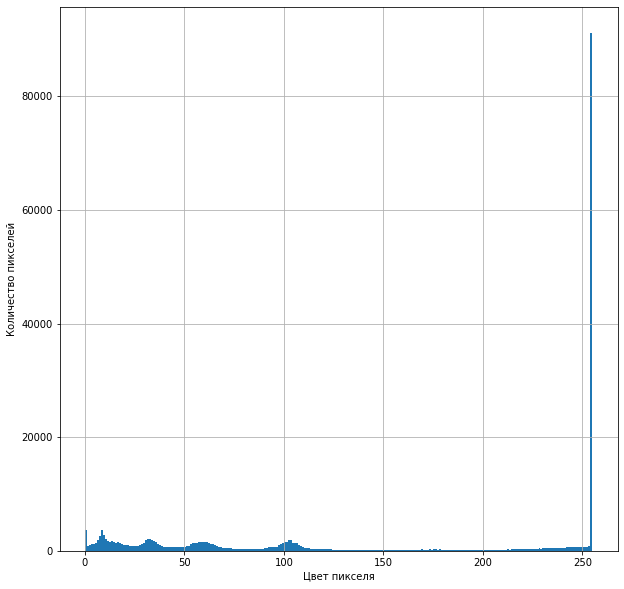

In [157]:
plt.figure(figsize=(10,10))

plt.hist(green.flatten(), bins = np.arange(256), histtype = 'bar')
plt.grid()
plt.xlabel('Цвет пикселя')
plt.ylabel('Количество пикселей')

plt.show()

In [147]:
#видим, что много белого фона поэтому 255 зашкаливает, можно обрезать, чтобы рассмотреть пики

In [148]:
green_cut = green[green < 255]

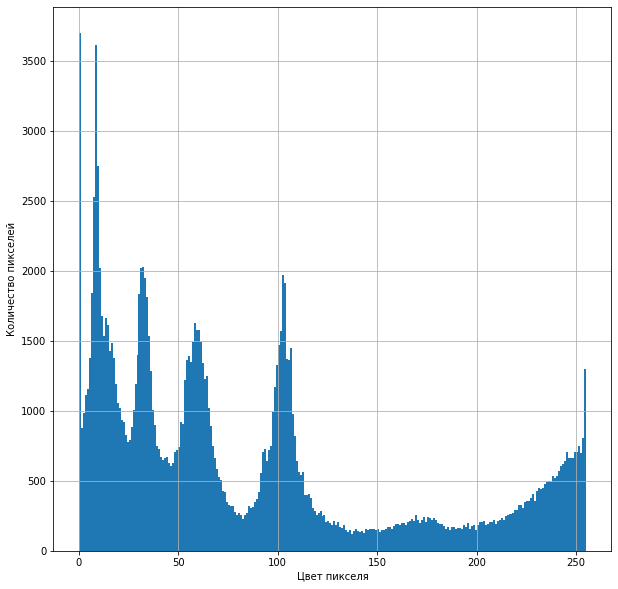

In [158]:
plt.figure(figsize=(10,10))
plt.hist(green_cut.flatten(), bins = np.arange(256)) 
plt.grid()

plt.xlabel('Цвет пикселя')
plt.ylabel('Количество пикселей')

plt.show()

Видим 4 явных пика со стороны ближе к 0, т.е. к черному цвету, которому соответствуют цвета самих кубиков. Обрезаем пиксели меньше 120, чтобы отделить сам кубик от количества очков на нем

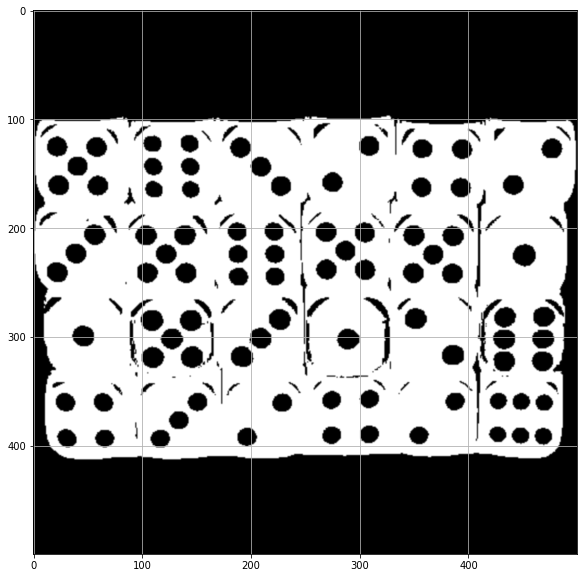

In [150]:
green_1 = green < 120
plt.figure(figsize=(10,10))

plt.imshow(green_1, cmap = cm.gray, interpolation = 'bicubic')
plt.grid()

plt.show()

https://en.wikipedia.org/wiki/Dilation_(morphology)
Сегментация изображения – это процесс разделения цифрового изображения на несколько сегментов, чтобы упростить и / или изменить представление изображения на что-то более значимое и более простое для анализа.

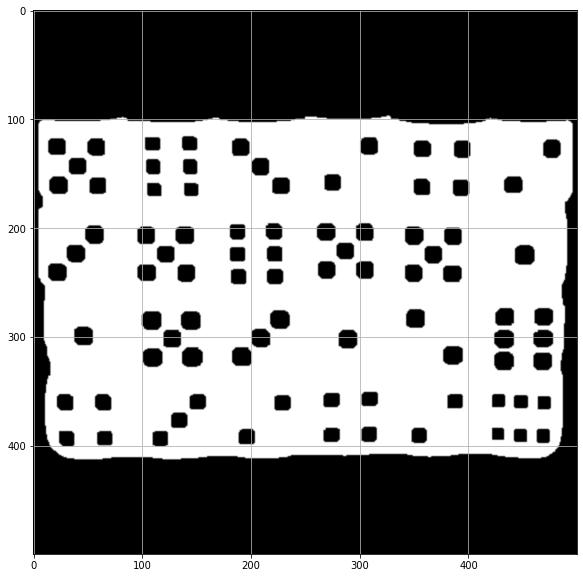

In [159]:
structure_element = np.ones((10,10)) #структурный элемент, который будет проходиться по пикселям бинарного изображения 
#и сначала сделает наращивание, а потом эрозию (определялся подбором вручную)
#https://habr.com/ru/post/113626/
green_1_dilation = ndimage.binary_dilation(green_1, structure = structure_element)
green_1_erosion = ndimage.binary_erosion(green_1_dilation, structure = structure_element)

plt.figure(figsize=(10,10))
plt.imshow(green_1_erosion, cmap = cm.gray, interpolation = 'bicubic')
plt.grid()

plt.show()

В результате применения операции эрозии все объекты, меньшие чем структурный элемент, стираются, объекты, соединённые тонкими линиями становятся разъединёнными и размеры всех объектов уменьшаются.

In [160]:
green_1_erosion_label, number = ndimage.measurements.label(green_1_erosion == False) #считаются области с фолсами
number

87

Label различает, а затем присваивает число ("маркировку") каждой из областей в двоичном изображении. Таким образом, он имеет 2 выхода: количество областей и массив с той же формой, что и входной, с пронумерованными областями. Получилось 87, т.к. учитывается большая область черного цвета. Нужно сделать так, чтобы она не учитывалась.

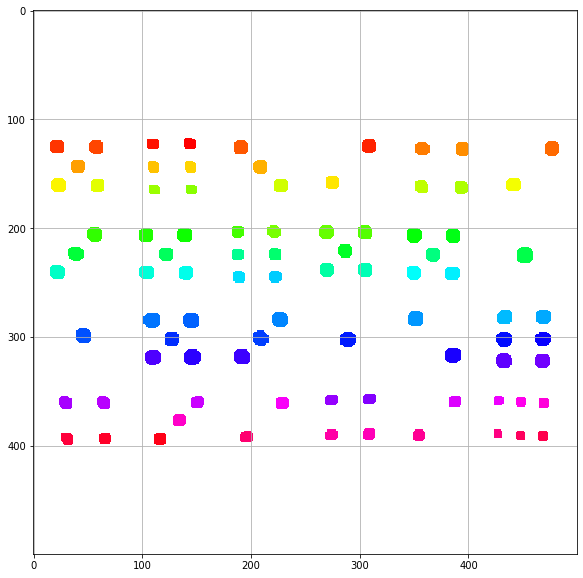

In [162]:
plt.figure(figsize=(10,10))
plt.imshow(np.where(green_1_erosion_label > 1, green_1_erosion_label, np.nan), 
           #где лейбл больше 1 осталяем, остальное заменяем на наны
           cmap = cm.hsv, interpolation = 'bicubic') #рисуем поверх цветные кубики где области попали в лейблы 
plt.grid()
plt.show()

In [164]:
pre_result = np.bincount(green_1_erosion_label.flatten())
pre_result

array([129224, 101680,    174,    165,    239,    230,    237,    240,
          250,    225,    227,    228,    238,    174,    174,    215,
          251,    239,    217,    229,    213,    215,    152,    152,
          206,    248,    239,    188,    262,    241,    254,    263,
          241,    225,    249,    299,    226,    189,    238,    178,
          236,    240,    252,    240,    240,    236,    241,    188,
          198,    252,    253,    271,    278,    282,    283,    268,
          263,    244,    266,    274,    259,    281,    304,    282,
          278,    276,    254,    187,    187,    210,    209,    199,
          178,    141,    201,    152,    142,    200,    187,    185,
          185,    120,    200,    141,    152,    186,    176,    189],
      dtype=int64)

In [166]:
result = (pre_result < 500).sum()
result

86

Вывод: на картинке с кубиками действительно 86 очков